In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
from urllib.request import urlopen
from bs4 import BeautifulSoup

import numpy as np
from os import path
from PIL import Image
import collections
import gensim
from gensim.models import Word2Vec
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/erdemsmac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pandas as pd

# Spark Configs

In [5]:
print(pyspark.__version__)

3.0.1


In [6]:
conf = pyspark.SparkConf().set("spark.jars.packages",
                              "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1").setMaster("local").setAppName("NLP").setAll([("spark.driver.memory","40g"),("spark.executor.memory","50g")])


In [7]:
sc = SparkContext(conf=conf)

In [8]:
sqlC = SQLContext(sc)

# Read MongoDB Collection

In [9]:
mongo_ip="mongodb://localhost:27017/example."

In [10]:
print(mongo_ip)

mongodb://localhost:27017/example.


In [11]:
davinci = sqlC.read.format("com.mongodb.spark.sql.DefaultSource").option("uri",mongo_ip + "davinci").load()

In [12]:
davinci.createOrReplaceTempView("davinci")

In [13]:
davinci = sqlC.sql("SELECT * FROM davinci")

In [14]:
davinci.show()

+--------------------+--------------------+
|               Datas|                 _id|
+--------------------+--------------------+
|8 °C2402:0000:002...|[611407fe62af0c44...|
+--------------------+--------------------+



# Spark to Dataframe

In [15]:
pandas_df = davinci.toPandas()

In [16]:
pandas_df= pandas_df.drop(["_id"],axis=1)

In [17]:
pandas_df

,Datas
0,8 °C2402:0000:0023:0022:0021:0020:0019:0018:00...


In [18]:
text=pandas_df.Datas[0]

In [19]:
print(text)

8 °C2402:0000:0023:0022:0021:0020:0019:0018:0017:3017:0011 Şubat 2016Da Vinci’nin Şifresi Kitap Özeti:Paris Louvre Müzesi müdürü Jarques Sauniere bir gece müzede esrarengiz bir cinayete kurban gitmiştir. Aslında o gece Harwardlı simgebilim profesörü Robert Longdan ile buluşacaktı. Profesor Longdon iş gezisi için Paristeydi ve Jorques Souniere ile de görüşmek istiyordu. Kendisinden randevu talep etmiş fakat herhangi bir cevap alamamıştı. Profesör Longdan aynı gece Hotel Ritz Parisin bir odasında kalıyordu. Fakat gece yarısı respsiyondan gelen telefonla uyandı.Da Vinci’nin Şifresi Kitap Özeti:Paris Louvre Müzesi müdürü Jarques Sauniere bir gece müzede esrarengiz bir cinayete kurban gitmiştir. Aslında o gece Harwardlı simgebilim profesörü Robert Longdan ile buluşacaktı. Profesor Longdon iş gezisi için Paristeydi ve Jorques Souniere ile de görüşmek istiyordu. Kendisinden randevu talep etmiş fakat herhangi bir cevap alamamıştı. Profesör Longdan aynı gece Hotel Ritz Parisin bir odasında kalı

In [20]:
def remove_punctuation(text):
    no_punc = [words for words in text if words not in string.punctuation]
    word_wo_punc = "".join(no_punc)
    return word_wo_punc

text = remove_punctuation(text)
print(text)

8 °C24020000002300220021002000190018001730170011 Şubat 2016Da Vinci’nin Şifresi Kitap ÖzetiParis Louvre Müzesi müdürü Jarques Sauniere bir gece müzede esrarengiz bir cinayete kurban gitmiştir Aslında o gece Harwardlı simgebilim profesörü Robert Longdan ile buluşacaktı Profesor Longdon iş gezisi için Paristeydi ve Jorques Souniere ile de görüşmek istiyordu Kendisinden randevu talep etmiş fakat herhangi bir cevap alamamıştı Profesör Longdan aynı gece Hotel Ritz Parisin bir odasında kalıyordu Fakat gece yarısı respsiyondan gelen telefonla uyandıDa Vinci’nin Şifresi Kitap ÖzetiParis Louvre Müzesi müdürü Jarques Sauniere bir gece müzede esrarengiz bir cinayete kurban gitmiştir Aslında o gece Harwardlı simgebilim profesörü Robert Longdan ile buluşacaktı Profesor Longdon iş gezisi için Paristeydi ve Jorques Souniere ile de görüşmek istiyordu Kendisinden randevu talep etmiş fakat herhangi bir cevap alamamıştı Profesör Longdan aynı gece Hotel Ritz Parisin bir odasında kalıyordu Fakat gece yarıs

# Lower word for Corpus

In [21]:
def corpus_lower(corpus):
    corpus = corpus.lower()
    return corpus

text = corpus_lower(text)
print(text)

8 °c24020000002300220021002000190018001730170011 şubat 2016da vinci’nin şifresi kitap özetiparis louvre müzesi müdürü jarques sauniere bir gece müzede esrarengiz bir cinayete kurban gitmiştir aslında o gece harwardlı simgebilim profesörü robert longdan ile buluşacaktı profesor longdon iş gezisi için paristeydi ve jorques souniere ile de görüşmek istiyordu kendisinden randevu talep etmiş fakat herhangi bir cevap alamamıştı profesör longdan aynı gece hotel ritz parisin bir odasında kalıyordu fakat gece yarısı respsiyondan gelen telefonla uyandıda vinci’nin şifresi kitap özetiparis louvre müzesi müdürü jarques sauniere bir gece müzede esrarengiz bir cinayete kurban gitmiştir aslında o gece harwardlı simgebilim profesörü robert longdan ile buluşacaktı profesor longdon iş gezisi için paristeydi ve jorques souniere ile de görüşmek istiyordu kendisinden randevu talep etmiş fakat herhangi bir cevap alamamıştı profesör longdan aynı gece hotel ritz parisin bir odasında kalıyordu fakat gece yarıs

# Remove numeric strings for clear text

In [22]:
def remove_numeric(corpus):
    output = ''.join(words for words in corpus if not words.isdigit())
    return output

text = remove_numeric(text)
text = text.replace("°c","")
print(text)

  şubat da vinci’nin şifresi kitap özetiparis louvre müzesi müdürü jarques sauniere bir gece müzede esrarengiz bir cinayete kurban gitmiştir aslında o gece harwardlı simgebilim profesörü robert longdan ile buluşacaktı profesor longdon iş gezisi için paristeydi ve jorques souniere ile de görüşmek istiyordu kendisinden randevu talep etmiş fakat herhangi bir cevap alamamıştı profesör longdan aynı gece hotel ritz parisin bir odasında kalıyordu fakat gece yarısı respsiyondan gelen telefonla uyandıda vinci’nin şifresi kitap özetiparis louvre müzesi müdürü jarques sauniere bir gece müzede esrarengiz bir cinayete kurban gitmiştir aslında o gece harwardlı simgebilim profesörü robert longdan ile buluşacaktı profesor longdon iş gezisi için paristeydi ve jorques souniere ile de görüşmek istiyordu kendisinden randevu talep etmiş fakat herhangi bir cevap alamamıştı profesör longdan aynı gece hotel ritz parisin bir odasında kalıyordu fakat gece yarısı respsiyondan gelen telefonla uyandıresoepsiyon gö

In [23]:
text = text.split()
text

['şubat',
 'da',
 'vinci’nin',
 'şifresi',
 'kitap',
 'özetiparis',
 'louvre',
 'müzesi',
 'müdürü',
 'jarques',
 'sauniere',
 'bir',
 'gece',
 'müzede',
 'esrarengiz',
 'bir',
 'cinayete',
 'kurban',
 'gitmiştir',
 'aslında',
 'o',
 'gece',
 'harwardlı',
 'simgebilim',
 'profesörü',
 'robert',
 'longdan',
 'ile',
 'buluşacaktı',
 'profesor',
 'longdon',
 'iş',
 'gezisi',
 'için',
 'paristeydi',
 've',
 'jorques',
 'souniere',
 'ile',
 'de',
 'görüşmek',
 'istiyordu',
 'kendisinden',
 'randevu',
 'talep',
 'etmiş',
 'fakat',
 'herhangi',
 'bir',
 'cevap',
 'alamamıştı',
 'profesör',
 'longdan',
 'aynı',
 'gece',
 'hotel',
 'ritz',
 'parisin',
 'bir',
 'odasında',
 'kalıyordu',
 'fakat',
 'gece',
 'yarısı',
 'respsiyondan',
 'gelen',
 'telefonla',
 'uyandıda',
 'vinci’nin',
 'şifresi',
 'kitap',
 'özetiparis',
 'louvre',
 'müzesi',
 'müdürü',
 'jarques',
 'sauniere',
 'bir',
 'gece',
 'müzede',
 'esrarengiz',
 'bir',
 'cinayete',
 'kurban',
 'gitmiştir',
 'aslında',
 'o',
 'gece',
 'har

# Stopwords

In [24]:
source = urlopen("https://github.com/stopwords-iso/stopwords-tr/blob/master/stopwords-tr.txt").read()
soup = BeautifulSoup(source, "lxml")
print(set([text.parent.name for text in soup.find_all(text=True)]))

{'details', 'template', 'include-fragment', 'tab-container', 'ul', 'nav', 'td', 'head', 'a', 'html', 'details-menu', 'h4', 'main', 'header', 'label', 'svg', 'details-dialog', 'li', 'clipboard-copy', 'div', 'form', '[document]', 'span', 'button', 'input-demux', 'ref-selector', 'title', 'table', 'strong', 'h2', 'tr', 'summary', 'h1', 'body'}


In [25]:
stopwords = ''

for paragraph in soup.find_all("tr"):
    stopwords += paragraph.text
    
stopwords = stopwords.split()
stopwords

['acaba',
 'acep',
 'adamakıllı',
 'adeta',
 'ait',
 'altmýþ',
 'altmış',
 'altý',
 'altı',
 'ama',
 'amma',
 'anca',
 'ancak',
 'arada',
 'artýk',
 'aslında',
 'aynen',
 'ayrıca',
 'az',
 'açıkça',
 'açıkçası',
 'bana',
 'bari',
 'bazen',
 'bazý',
 'bazı',
 'başkası',
 'baţka',
 'belki',
 'ben',
 'benden',
 'beni',
 'benim',
 'beri',
 'beriki',
 'beþ',
 'beş',
 'beţ',
 'bilcümle',
 'bile',
 'bin',
 'binaen',
 'binaenaleyh',
 'bir',
 'biraz',
 'birazdan',
 'birbiri',
 'birden',
 'birdenbire',
 'biri',
 'birice',
 'birileri',
 'birisi',
 'birkaç',
 'birkaçı',
 'birkez',
 'birlikte',
 'birçok',
 'birçoğu',
 'birþey',
 'birþeyi',
 'birşey',
 'birşeyi',
 'birţey',
 'bitevi',
 'biteviye',
 'bittabi',
 'biz',
 'bizatihi',
 'bizce',
 'bizcileyin',
 'bizden',
 'bize',
 'bizi',
 'bizim',
 'bizimki',
 'bizzat',
 'boşuna',
 'bu',
 'buna',
 'bunda',
 'bundan',
 'bunlar',
 'bunları',
 'bunların',
 'bunu',
 'bunun',
 'buracıkta',
 'burada',
 'buradan',
 'burası',
 'böyle',
 'böylece',
 'böylecene',


In [26]:
filtered_text = []

for word in text:
    if word not in stopwords:
        filtered_text.append(word)

filtered_text

['şubat',
 'vinci’nin',
 'şifresi',
 'kitap',
 'özetiparis',
 'louvre',
 'müzesi',
 'müdürü',
 'jarques',
 'sauniere',
 'gece',
 'müzede',
 'esrarengiz',
 'cinayete',
 'kurban',
 'gitmiştir',
 'gece',
 'harwardlı',
 'simgebilim',
 'profesörü',
 'robert',
 'longdan',
 'buluşacaktı',
 'profesor',
 'longdon',
 'gezisi',
 'paristeydi',
 'jorques',
 'souniere',
 'görüşmek',
 'istiyordu',
 'kendisinden',
 'randevu',
 'talep',
 'etmiş',
 'cevap',
 'alamamıştı',
 'profesör',
 'longdan',
 'aynı',
 'gece',
 'hotel',
 'ritz',
 'parisin',
 'odasında',
 'kalıyordu',
 'gece',
 'yarısı',
 'respsiyondan',
 'gelen',
 'telefonla',
 'uyandıda',
 'vinci’nin',
 'şifresi',
 'kitap',
 'özetiparis',
 'louvre',
 'müzesi',
 'müdürü',
 'jarques',
 'sauniere',
 'gece',
 'müzede',
 'esrarengiz',
 'cinayete',
 'kurban',
 'gitmiştir',
 'gece',
 'harwardlı',
 'simgebilim',
 'profesörü',
 'robert',
 'longdan',
 'buluşacaktı',
 'profesor',
 'longdon',
 'gezisi',
 'paristeydi',
 'jorques',
 'souniere',
 'görüşmek',
 'is

## MaskImage for WordCloud

In [27]:
mask = np.array(Image.open("/Users/erdemsmac/Desktop/mask2.jpg"))
mask

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

# WordCloud!!

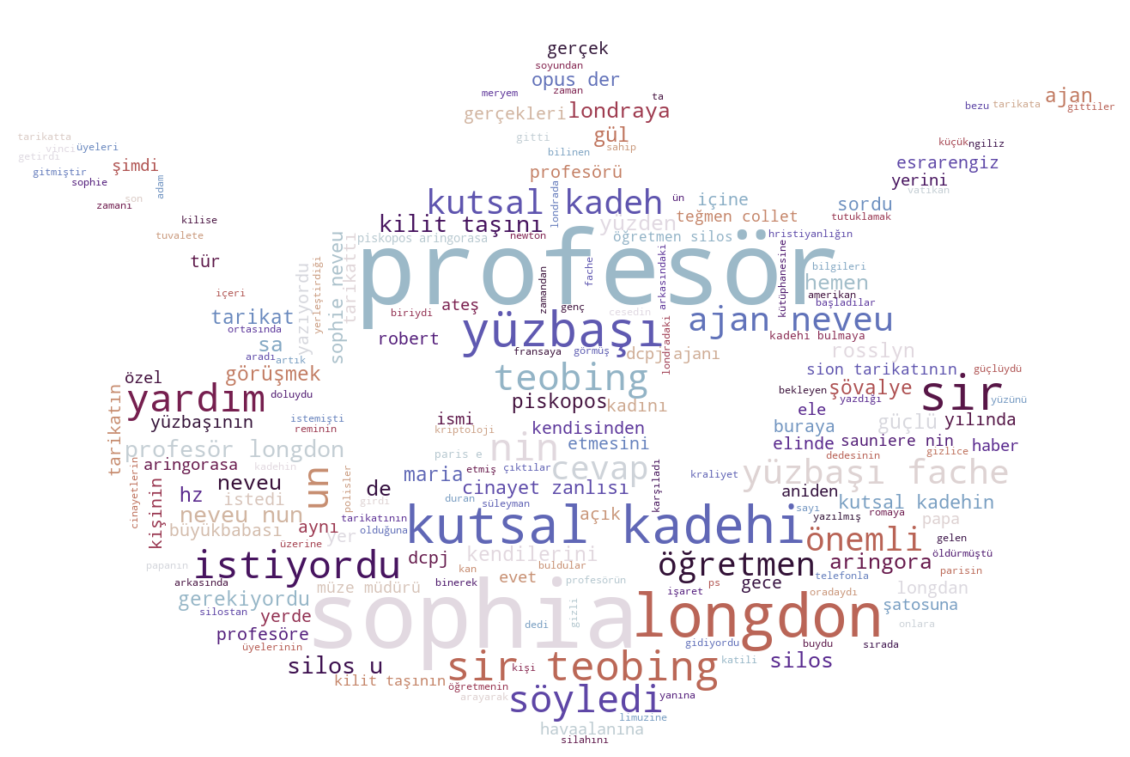

In [28]:
sentence = []

for i in filtered_text:
    sentence.append(i)
    
text_ = " ".join(map(str, sentence)) 

wordcloud = WordCloud(width = 3000, 
                      height = 3000, 
                      max_font_size = 300, 
                      background_color="white",
                      mask=mask,
                      colormap = "twilight_shifted").generate(text_)

plt.figure(figsize = (20,17))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [29]:
corpus = []

for cumle in filtered_text:
    corpus.append(cumle.split())
    
corpus

[['şubat'],
 ['vinci’nin'],
 ['şifresi'],
 ['kitap'],
 ['özetiparis'],
 ['louvre'],
 ['müzesi'],
 ['müdürü'],
 ['jarques'],
 ['sauniere'],
 ['gece'],
 ['müzede'],
 ['esrarengiz'],
 ['cinayete'],
 ['kurban'],
 ['gitmiştir'],
 ['gece'],
 ['harwardlı'],
 ['simgebilim'],
 ['profesörü'],
 ['robert'],
 ['longdan'],
 ['buluşacaktı'],
 ['profesor'],
 ['longdon'],
 ['gezisi'],
 ['paristeydi'],
 ['jorques'],
 ['souniere'],
 ['görüşmek'],
 ['istiyordu'],
 ['kendisinden'],
 ['randevu'],
 ['talep'],
 ['etmiş'],
 ['cevap'],
 ['alamamıştı'],
 ['profesör'],
 ['longdan'],
 ['aynı'],
 ['gece'],
 ['hotel'],
 ['ritz'],
 ['parisin'],
 ['odasında'],
 ['kalıyordu'],
 ['gece'],
 ['yarısı'],
 ['respsiyondan'],
 ['gelen'],
 ['telefonla'],
 ['uyandıda'],
 ['vinci’nin'],
 ['şifresi'],
 ['kitap'],
 ['özetiparis'],
 ['louvre'],
 ['müzesi'],
 ['müdürü'],
 ['jarques'],
 ['sauniere'],
 ['gece'],
 ['müzede'],
 ['esrarengiz'],
 ['cinayete'],
 ['kurban'],
 ['gitmiştir'],
 ['gece'],
 ['harwardlı'],
 ['simgebilim'],
 ['pro

# Word2Vec model 

In [30]:
model = Word2Vec(corpus,  window = 2, min_count = 2, sg = 1)
model

In [31]:
model.wv["müze"]

array([-0.00274263,  0.00010893,  0.00203456, -0.00928968,  0.00483915,
        0.00337212, -0.00017393, -0.00349733, -0.00760466,  0.00759605,
       -0.00860319, -0.0073842 ,  0.00445166, -0.00851143, -0.00328415,
       -0.00209056, -0.00190278, -0.00683529,  0.00429652,  0.00099886,
        0.00365659, -0.00132833,  0.00693502, -0.00953359,  0.00584622,
       -0.00513144,  0.00170328, -0.00694106, -0.00248122, -0.00642885,
       -0.00335099,  0.00972953,  0.00268972,  0.00160534, -0.00608383,
        0.00557297, -0.00812862, -0.00229347, -0.00646841, -0.00638226,
        0.00229702, -0.00328671,  0.00243008,  0.00391644, -0.00627002,
       -0.0017449 , -0.00276249, -0.00979631, -0.0098386 ,  0.00111001,
        0.00438087,  0.00023249, -0.004872  ,  0.00362778,  0.00168863,
       -0.00944161,  0.00718844,  0.00777315, -0.00773156, -0.00076449,
        0.00603131, -0.00278046, -0.00033712, -0.00421984,  0.00611463,
        0.00699556,  0.00208625, -0.00469956, -0.00183011, -0.00

In [32]:
model.wv["dünya"]

array([-8.4853936e-03,  7.1567418e-03,  3.4934878e-03,  9.6848151e-03,
        4.0974496e-03,  4.9892900e-04,  6.0007069e-03,  9.0264558e-04,
        7.6638008e-03,  8.3594490e-03, -4.3485737e-03, -3.8900066e-03,
        3.9129471e-03,  5.0612929e-04,  7.6281382e-03,  7.1658324e-03,
        6.8873549e-03,  5.8819964e-03, -2.1676612e-03,  6.2367036e-03,
        9.5913745e-03, -1.3750267e-03,  1.3980246e-03,  1.0535956e-03,
        3.1348991e-03,  4.9272822e-03, -8.4958840e-03, -7.3248078e-03,
       -2.0856094e-03, -3.8413620e-03, -3.3297229e-03,  4.0525128e-03,
       -9.6808029e-03,  5.7852268e-03,  6.4120698e-03, -2.5929450e-03,
        2.9512239e-03,  2.3697638e-03,  7.0575164e-03,  4.0016458e-03,
        2.3429561e-03,  7.2764540e-03, -1.1160374e-05, -8.1085609e-03,
       -4.7321701e-03, -6.5909694e-03, -2.6633167e-03,  8.3432440e-03,
       -9.3288086e-03, -1.6663766e-03, -5.6180977e-03, -3.4168125e-03,
        3.9733076e-03,  8.8943625e-03, -6.2815975e-03, -3.0664825e-03,
      

# Each word is actually a decimal number(Float to Int)!

In [33]:
#Önemli
model.wv.most_similar(int(1.80985685e-03))

[('kelimeleri', 0.3595535457134247),
 ('yardımcı', 0.289742112159729),
 ('kasasının', 0.27770087122917175),
 ('polisler', 0.275379478931427),
 ('etmiş', 0.27314674854278564),
 ('olacaktı', 0.26645752787590027),
 ('leoning', 0.2580290138721466),
 ('kolaylıkla', 0.2442401796579361),
 ('aingorasa', 0.2434554398059845),
 ('edinburg’un', 0.230483740568161)]

In [34]:
model.wv.most_similar(int(-0.0073842))

[('kelimeleri', 0.3595535457134247),
 ('yardımcı', 0.289742112159729),
 ('kasasının', 0.27770087122917175),
 ('polisler', 0.275379478931427),
 ('etmiş', 0.27314674854278564),
 ('olacaktı', 0.26645752787590027),
 ('leoning', 0.2580290138721466),
 ('kolaylıkla', 0.2442401796579361),
 ('aingorasa', 0.2434554398059845),
 ('edinburg’un', 0.230483740568161)]

# Top10 Most Similar of Words

In [35]:
model.wv.most_similar("dünya")

[('arkasında', 0.3245311379432678),
 ('neveuya', 0.29989516735076904),
 ('silinmişti', 0.2928750813007355),
 ('büyükbabasıyla', 0.2914997935295105),
 ('harita', 0.27742213010787964),
 ('eline', 0.2759018838405609),
 ('silosa', 0.26041680574417114),
 ('ediyordu', 0.25320497155189514),
 ('değerliydi', 0.2524484097957611),
 ('kişiyi', 0.24541641771793365)]

In [36]:
model.wv.most_similar("merkez")

[('tümünde', 0.31766054034233093),
 ('odanıza', 0.2989277243614197),
 ('mesaja', 0.2945449650287628),
 ('atlatmak', 0.29333803057670593),
 ('cinayet', 0.27751821279525757),
 ('kişiler', 0.2746909558773041),
 ('soyundan', 0.2584207057952881),
 ('katili', 0.25609394907951355),
 ('ipuçları', 0.2535712420940399),
 ('kendisiydi', 0.24618594348430634)]

In [37]:
model.wv.most_similar("vinci")

[('kadehin', 0.3188098669052124),
 ('buluşacaktı', 0.3107635974884033),
 ('ta', 0.3021996021270752),
 ('taksikte', 0.30124959349632263),
 ('aringoraya', 0.29853639006614685),
 ('cesedi', 0.2723064720630646),
 ('yardımıyla', 0.27191296219825745),
 ('belge', 0.27076661586761475),
 ('papazlar', 0.2591855823993683),
 ('sinyali', 0.25669100880622864)]

In [38]:
model.wv.most_similar("longdon")

[('bilgileri', 0.31768563389778137),
 ('aniden', 0.3076630234718323),
 ('secrets', 0.30191996693611145),
 ('i̇sa’dan', 0.29206714034080505),
 ('ateş', 0.27950751781463623),
 ('devini', 0.2789996564388275),
 ('müzeye', 0.2759874165058136),
 ('londrada”', 0.2728365361690521),
 ('sorular', 0.2623494267463684),
 ('aydınlanabileceğini', 0.24859930574893951)]

# Bigram & Trigram

In [39]:
bigrams = (pd.Series(nltk.ngrams(corpus, 2)).value_counts())[:20]

Text(0.5, 0, 'Occurances')

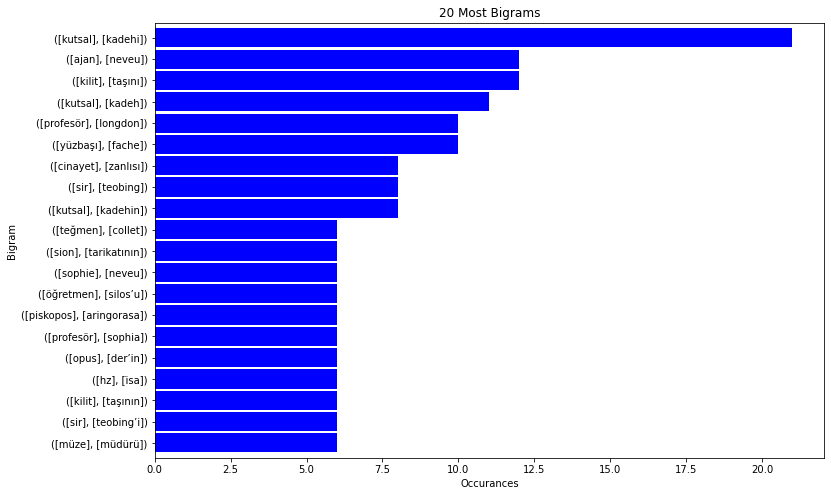

In [40]:
bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Occurances')

In [41]:
model.wv.similarity('dünya','harita')

0.27742207

In [42]:
model.wv.similarity(int(-0.0073842),int(0.27314674854278564))

1.0

In [43]:
model.wv.similarity('dünya','merkez')

-0.08491804

In [44]:
trigrams = (pd.Series(nltk.ngrams(corpus, 3)).value_counts())[:20]

Text(0.5, 0, 'Occurances')

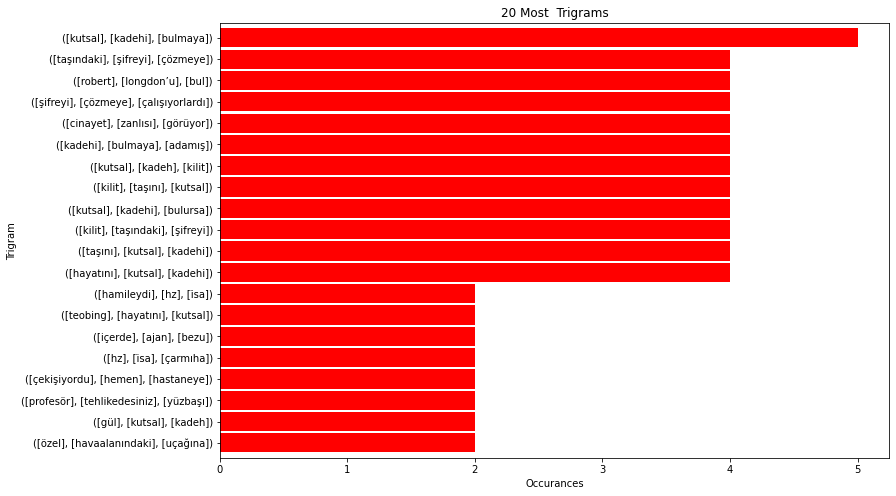

In [45]:
trigrams.sort_values().plot.barh(color='red', width=.9, figsize=(12, 8))
plt.title('20 Most  Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Occurances')

# Cosine Similatiry

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [75]:
count_vect = CountVectorizer()
Document1= "Davinci iyi bir adamdır"
Document2= "Davinci kötü bir adamdır"

In [76]:
simicorpus = [Document1,Document2]

In [77]:
X_train_counts = count_vect.fit_transform(simicorpus)

In [78]:
pd.DataFrame(X_train_counts.toarray(),columns=count_vect.get_feature_names(),index=['Document 0','Document 1'])

,adamdır,bir,davinci,iyi,kötü
Document 0,1,1,1,1,0
Document 1,1,1,1,0,1


In [79]:
vectorizer = TfidfVectorizer()
trsfm=vectorizer.fit_transform(simicorpus)
pd.DataFrame(trsfm.toarray(),columns=vectorizer.get_feature_names(),index=['Document 0','Document 1'])

,adamdır,bir,davinci,iyi,kötü
Document 0,0.448321,0.448321,0.448321,0.630099,0.000000
Document 1,0.448321,0.448321,0.448321,0.000000,0.630099


In [80]:
cosine_similarity(trsfm[0:1], trsfm)

array([[1.        , 0.60297482]])

# Soft Cosine Similarity